In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib

## Preparations

In [2]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # number of iterations on confounder-based partitions
algs = ['ARACNE', 'CEMITOOL', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms
confs = ['age', 'ethnicity', 'sex', 'alcohol history', 'smoking history', 'stage']
ct_sels = ['METABRIC', 'BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUAD', 'LUSC', 'PCPG', 'READ', 'STAD']
alpha = 0.05

## Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [3]:
JI_all = pd.read_csv('JI_all.csv')

## Generate plots for supplement

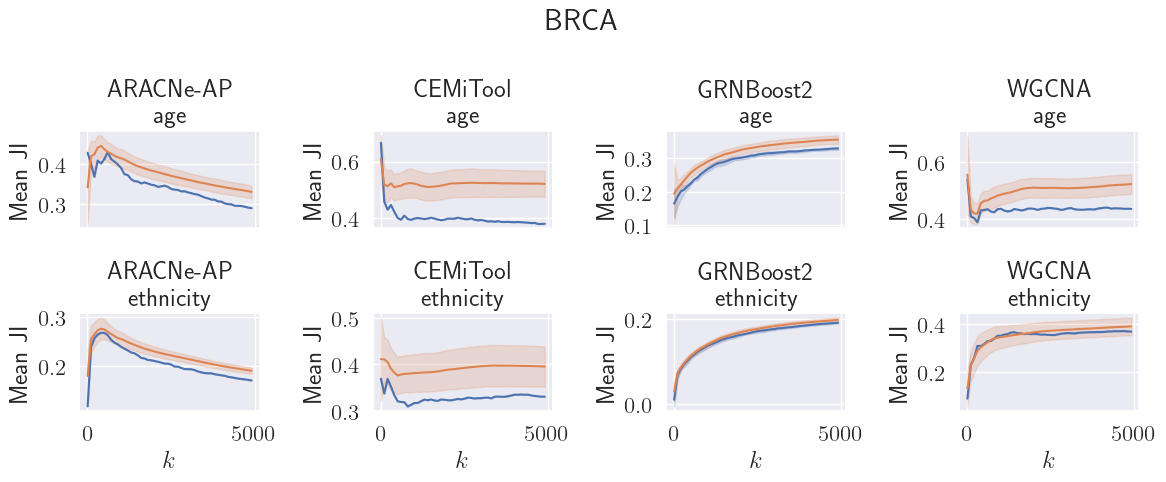

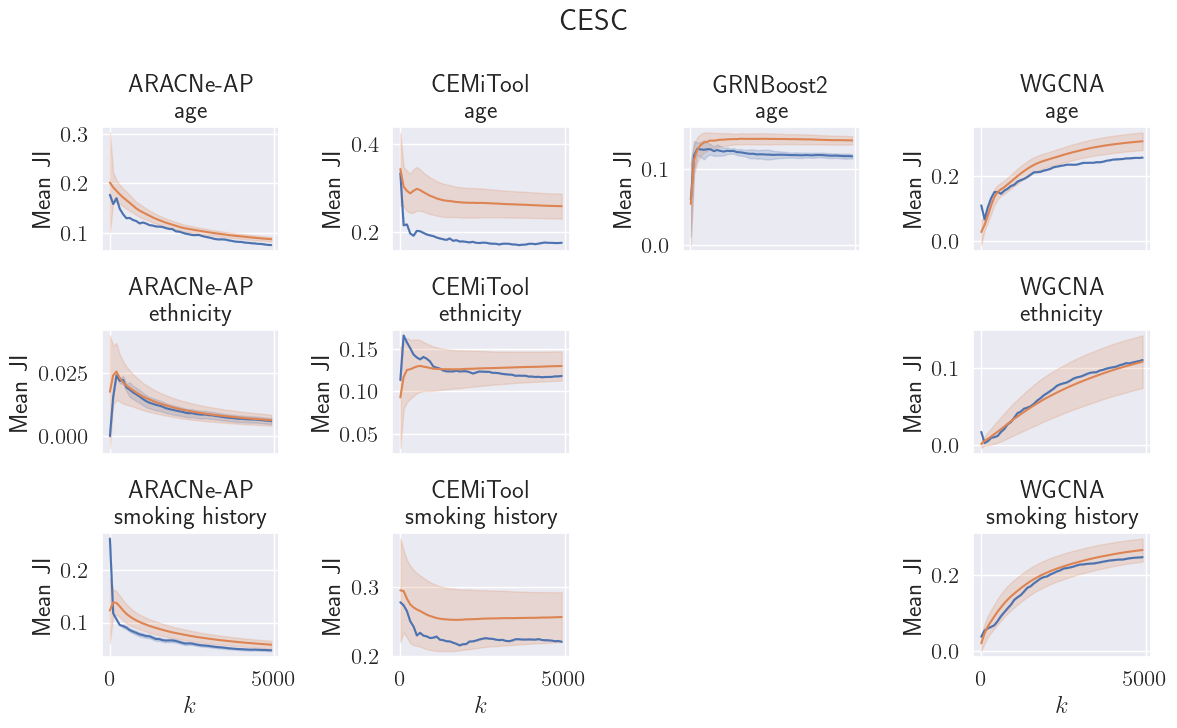

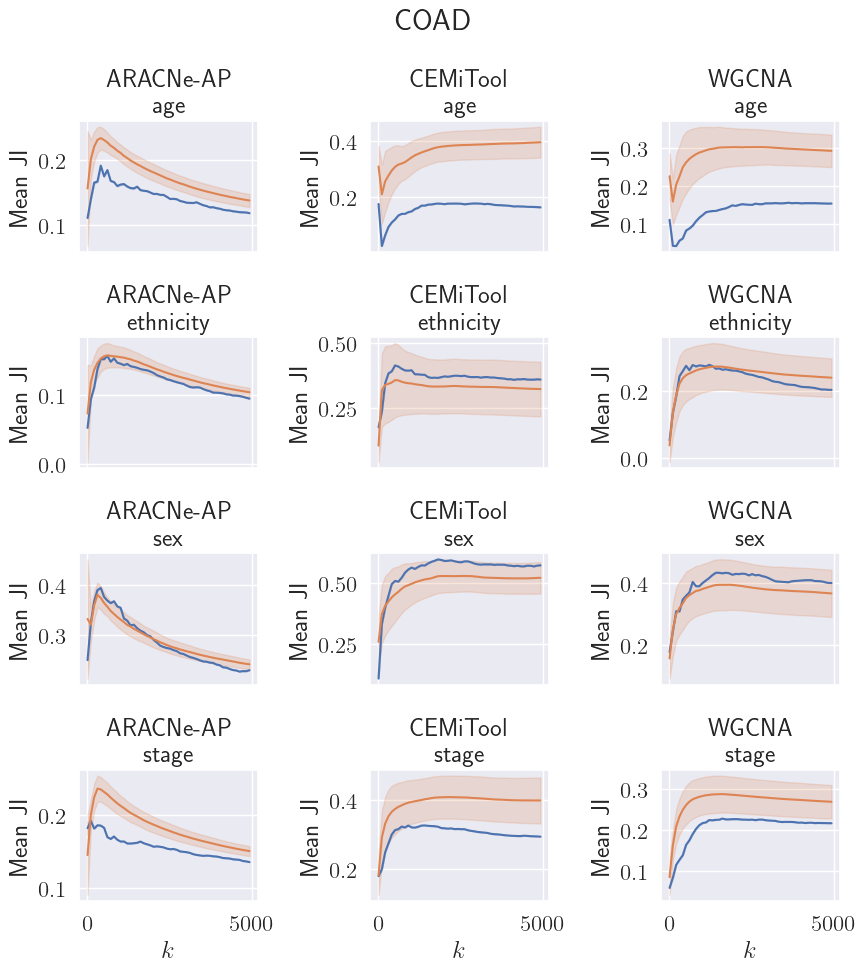

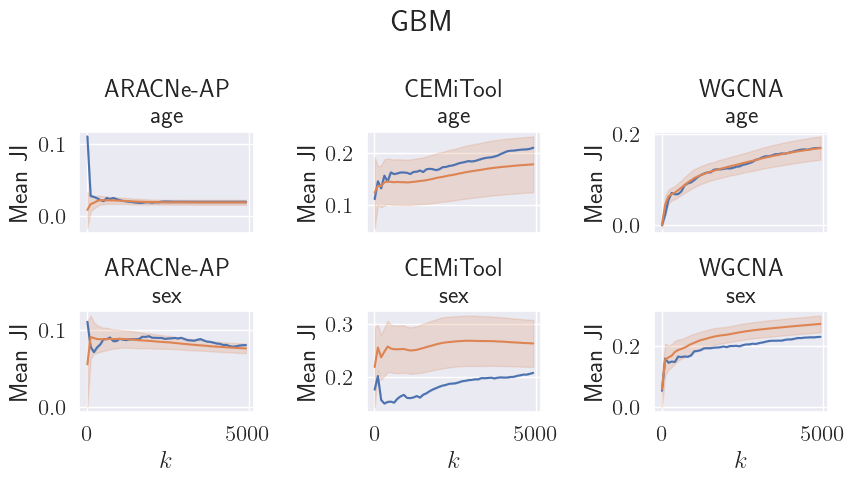

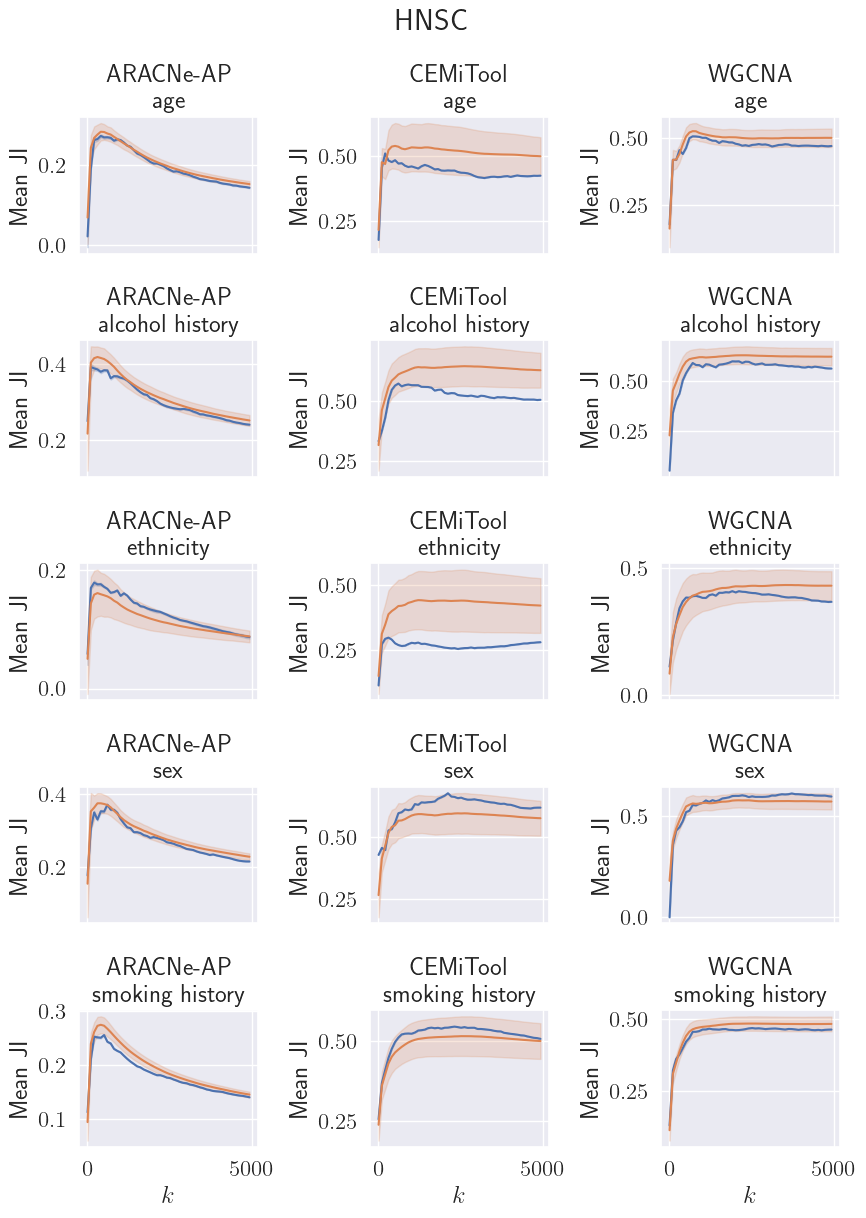

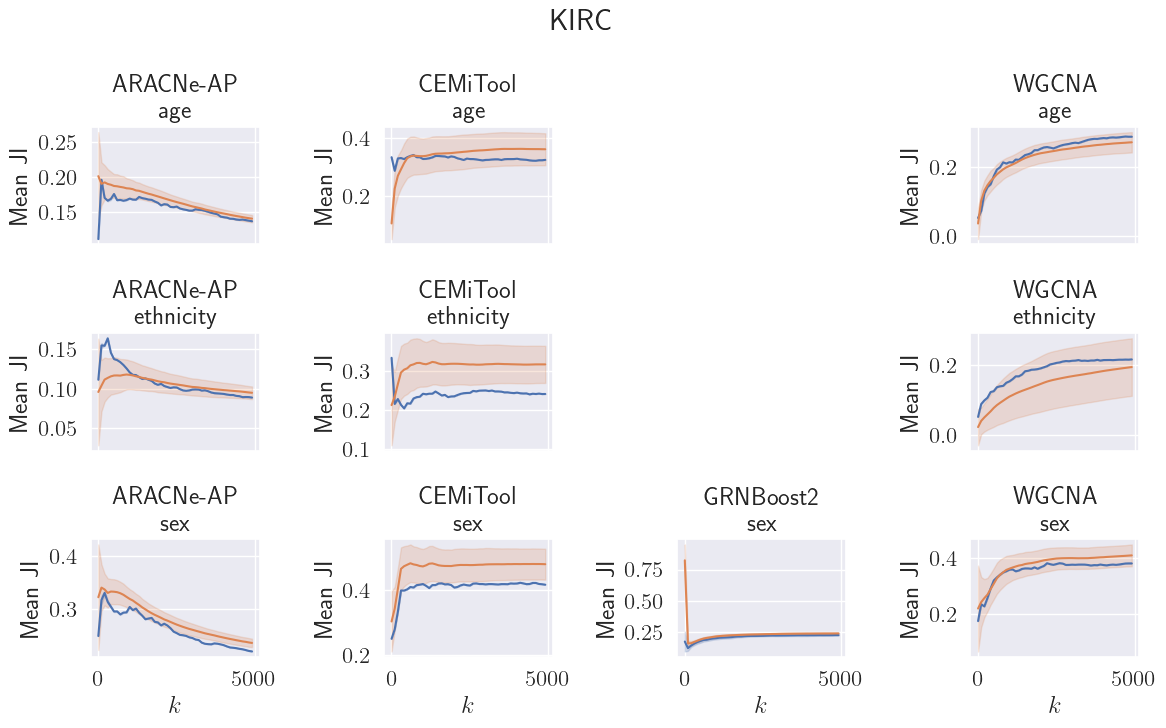

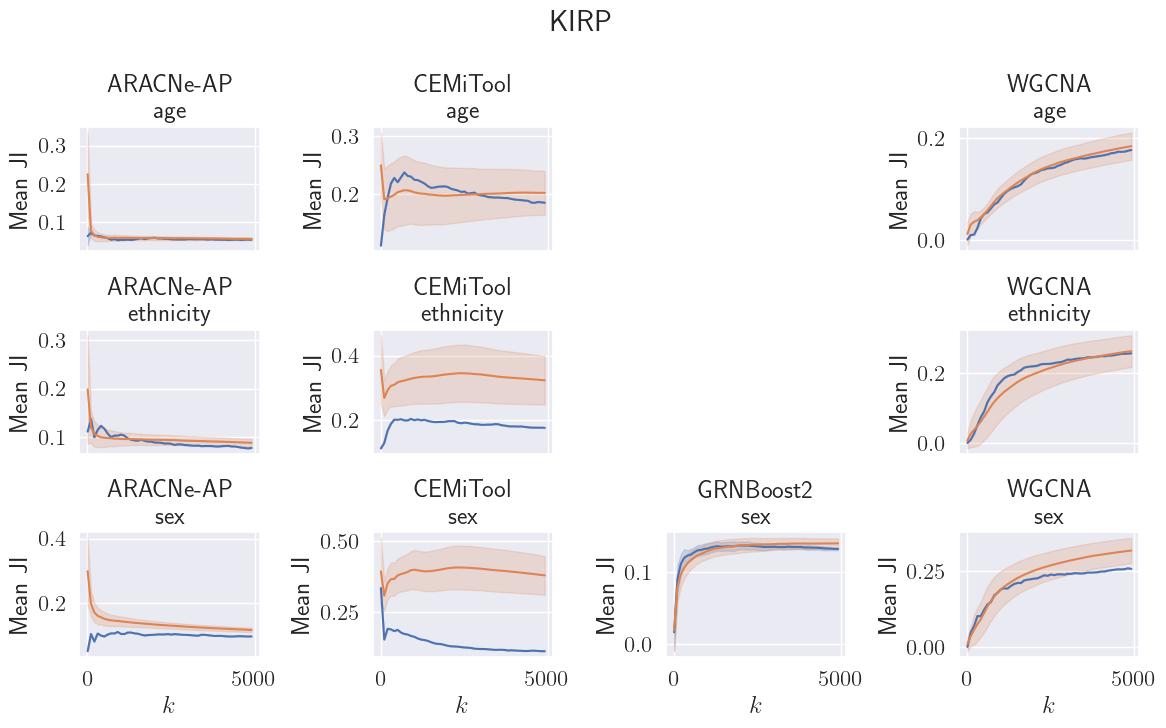

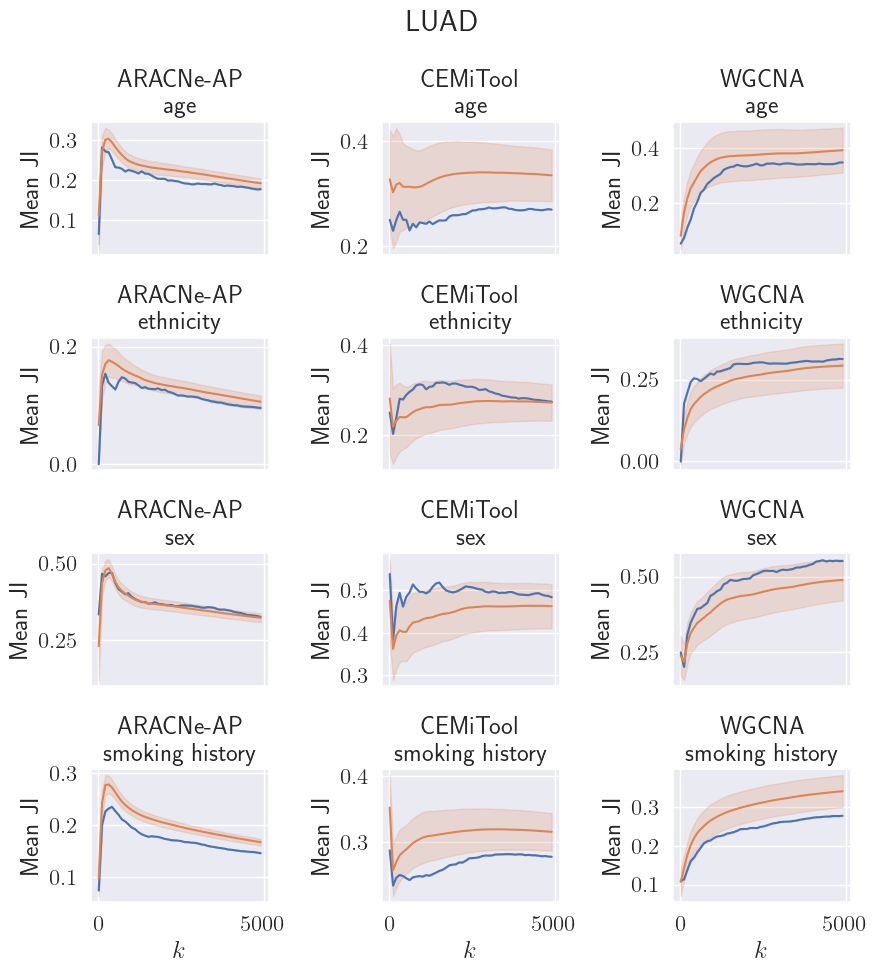

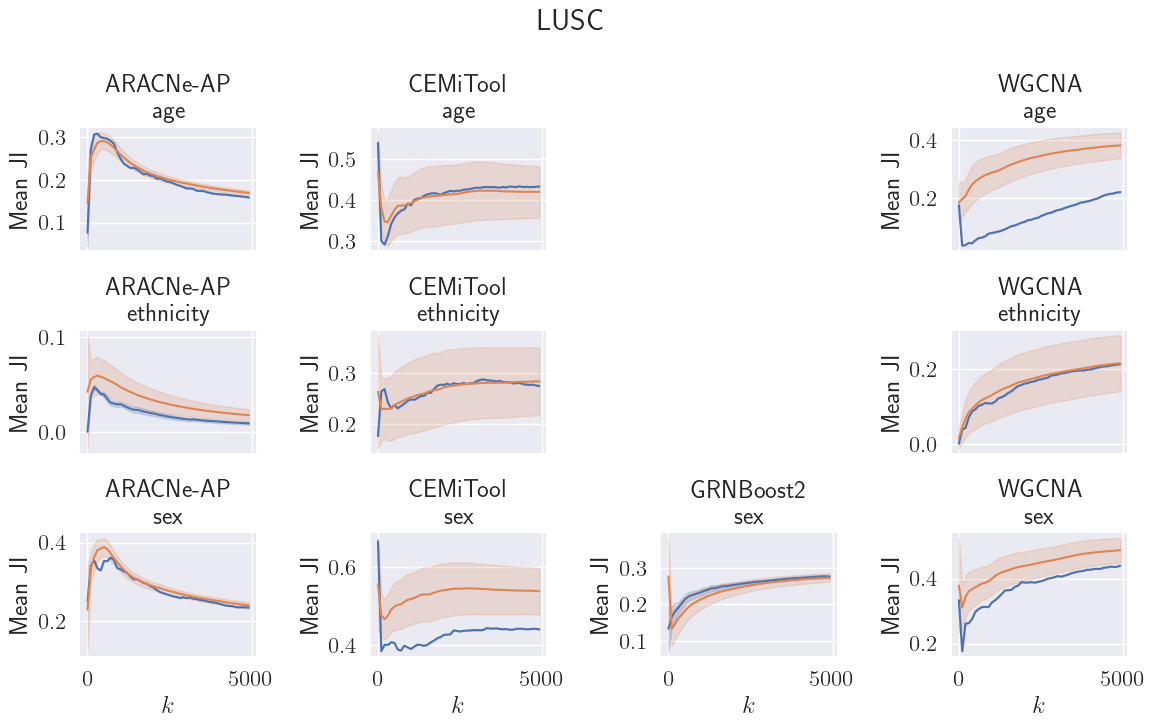

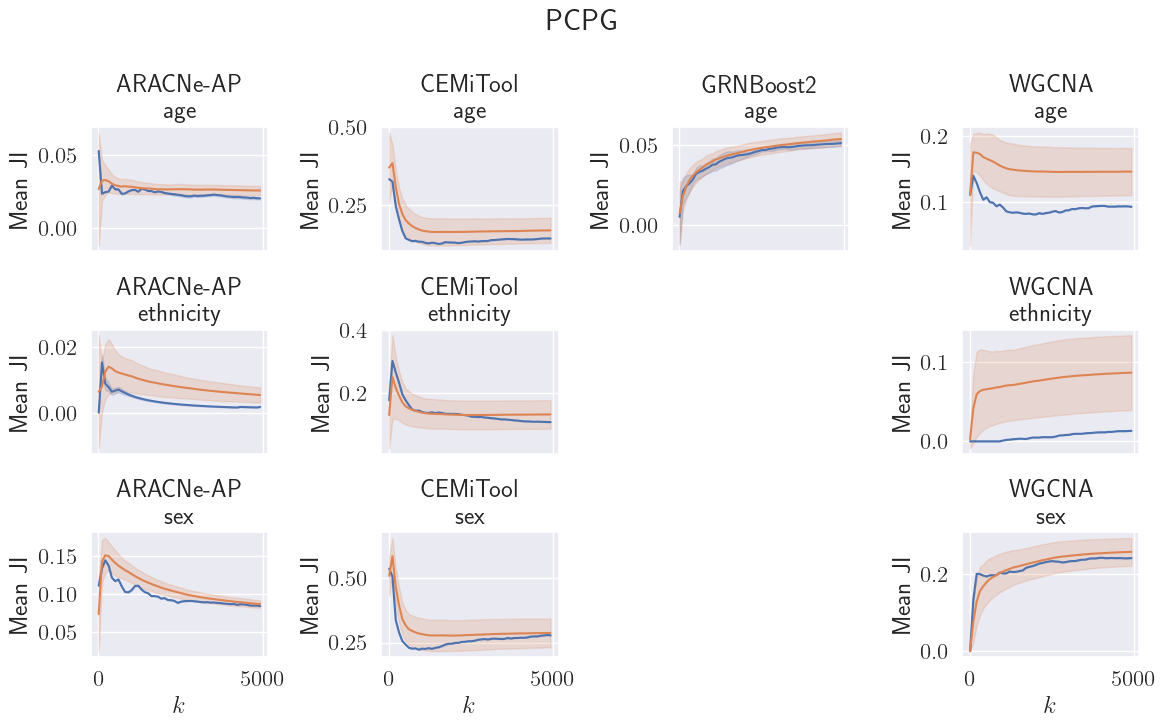

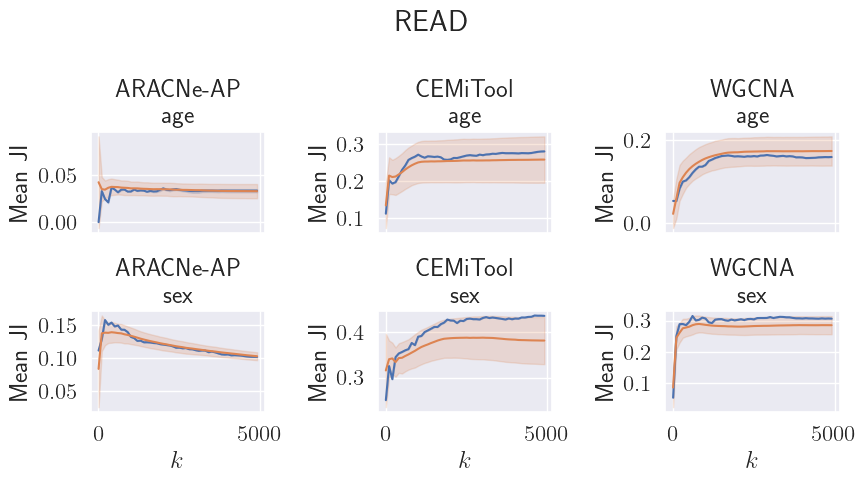

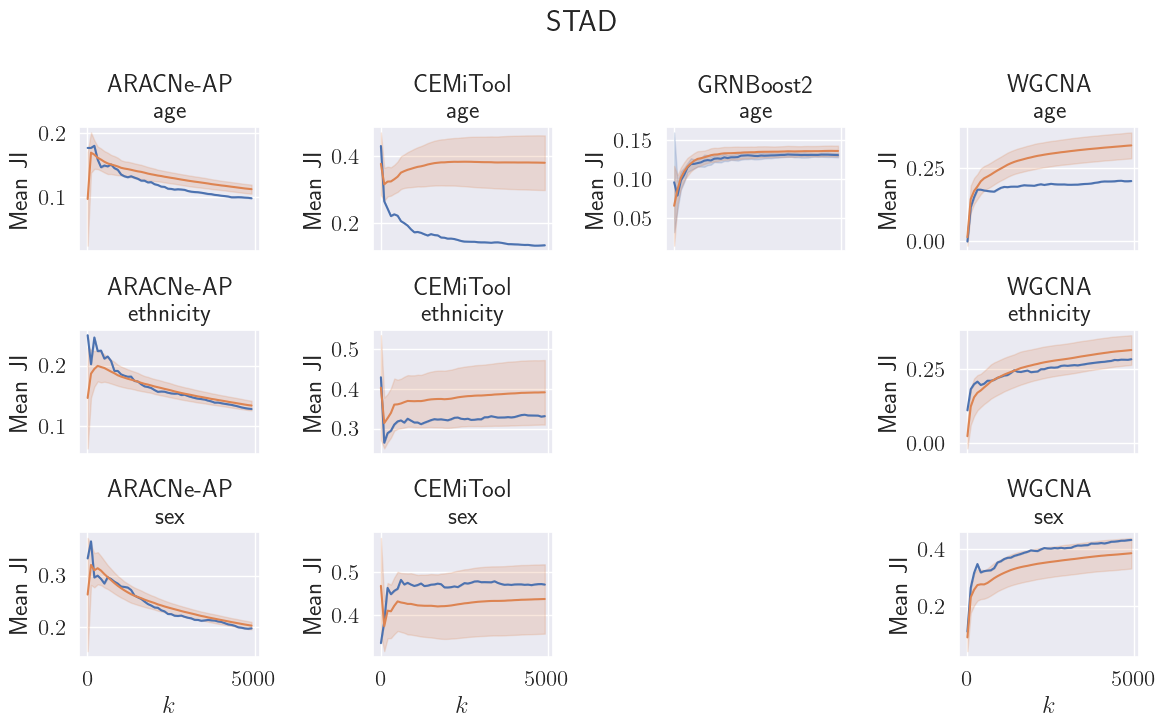

In [21]:
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
for ct_sel in ct_sels:
    JI_ct = JI_all[JI_all['Cohort']==ct_sel]
    confounders = sorted(list(set(JI_ct['Confounder/\nvariable'].values)))
    algos = sorted(list(set(JI_ct['Method'].values)))
    if len(confounders) == 1:
        fig, axs = plt.subplots(1, len(algos), figsize=(3.2*len(algos), 3.5*len(confounders)), sharex=True, sharey=False)
    else:
        fig, axs = plt.subplots(len(confounders), len(algos), figsize=(3*len(algos), 2.5*len(confounders)), sharex=True, sharey=False)
    for i, conf in enumerate(confounders):
        JI_conf = JI_ct[JI_ct['Confounder/\nvariable'] == conf]
        for j, algo in enumerate(algos):
            JI_alg = JI_conf[JI_conf['Method'] == algo]
            if JI_alg.shape[0] == 0:
                axs[i, j].axis('off')
            else:
                try:
                    sns.lineplot(data=JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[i,j], hue='Partition type', legend=False)
                    axs[i,j].set_title(f'{algo}\n{conf}')
                    axs[i,j].set_xlabel('$k$')
                except IndexError:
                    sns.lineplot(data=JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[j], hue='Partition type', legend=False)
                    axs[j].set_title(f'{algo}\n{conf}')
                    axs[j].set_xlabel('$k$')
    fig.suptitle(ct_sel)
    fig.tight_layout()
    fig.savefig(f'plots/{ct_sel}_block_comparisons.pdf')

## Read P-values of one-sided Mann-Whitney U-test for each k for fast methods

In [40]:
_mwus = pd.read_csv('mwus_conf.csv')
corr_coeff= _mwus.pivot(columns='Method',values='frac',index=['Cohort','Confounder/\nvariable']).corr()

## Read P-values of one-sided Mann-Whitney U-test for each k for GRNBoost2

In [41]:
mwus = pd.read_csv('mwus_conf_grnboost2.csv')
cohort_confs = [val for val in sorted(list(set(mwus['Cohort - Variable'].values))) if 'METABRIC' not in val]

## Generate plots for method-centric view

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/2776556254.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _mwus_alg['Confounder/\nvariable'] = pd.Categorical(_mwus_alg['Confounder/\nvariable'], ['age', 'ethnicity', 'sex'])
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/2776556254.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _mwus_alg['Confounder/\nvariable'] = pd.Categorical(_mwus_alg['Confounder/\nvariable'], ['age', 'ethnicity', 'sex'])
/var/folders/71/cy2w33

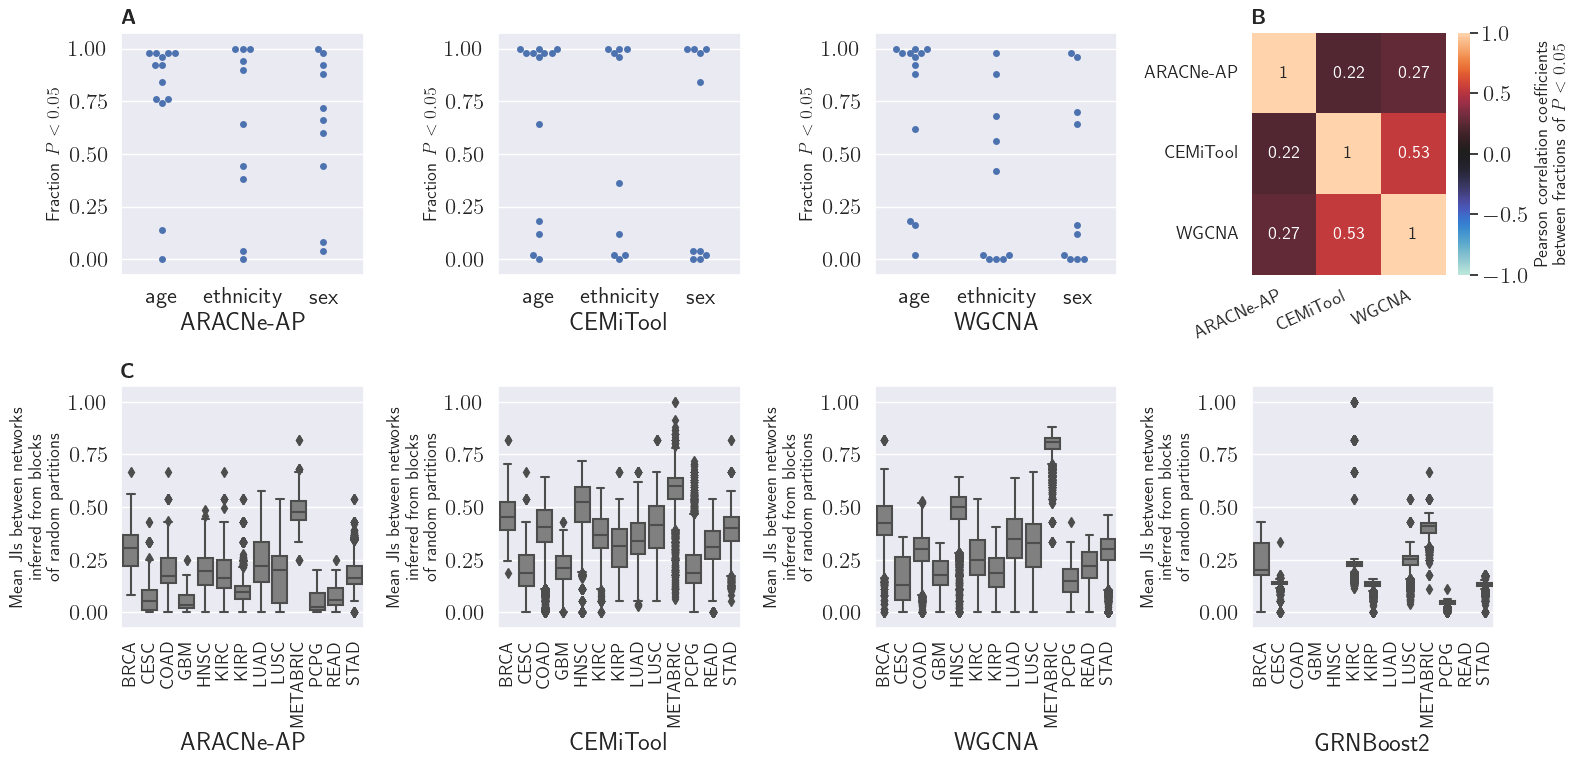

In [22]:
JI_all_random = JI_all[JI_all['Partition type'] == 'random partition']
JI_all_random = JI_all_random[JI_all_random['Confounder/\nvariable'] != 'stage']
JI_all_random = JI_all_random[JI_all_random['Confounder/\nvariable'] != 'alcohol history']
JI_all_random = JI_all_random[JI_all_random['Confounder/\nvariable'] != 'smoking history']
JI_all_random['Confounder/\nvariable'] = pd.Categorical(JI_all_random['Confounder/\nvariable'], ['age', 'ethnicity', 'sex'])

plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',{'axes.grid' : True})
confounders = ['age', 'ethnicity', 'sex']#sorted(list(set(JI_all_random['Confounder/\nvariable'].values)))
algos = ['ARACNe-AP','CEMiTool','WGCNA','GRNBoost2']
cohorts = sorted(list(set(JI_all_random['Cohort'].values)))
mosaic = [['ARACNe-AP','CEMiTool','WGCNA','heatmap'],
          ['ARACNe-AP,r','CEMiTool,r','WGCNA,r','GRNBoost2,r']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(4*4, 4*2),sharex=False, sharey=False)
for algo in ['ARACNe-AP','CEMiTool','WGCNA']:
    axs[algo].set_ylim([-0.075, 1.075])
    _mwus_alg = _mwus[_mwus['Method'] == algo]
    _mwus_alg['Confounder/\nvariable'] = pd.Categorical(_mwus_alg['Confounder/\nvariable'], ['age', 'ethnicity', 'sex'])
    sns.swarmplot(data=_mwus_alg,y='frac',x='Confounder/\nvariable',ax=axs[algo])
    axs[algo].set_ylabel('Fraction $P<0.05$',fontsize=13)
    axs[algo].set_xlabel(algo)
for algo in algos:
    conf_alg = f'{algo},r'
    axs[conf_alg].set_ylim([-0.075, 1.075])
    JI_alg = JI_all_random[JI_all_random['Method'] == algo]
    sns.boxplot(data=JI_alg,y='Mean JI',x='Cohort',ax=axs[conf_alg],order=cohorts,color='grey')
    axs[conf_alg].set_ylabel('Mean JIs between networks\ninferred from blocks\nof random partitions',fontsize=13)
    axs[conf_alg].set_xlabel(algo)
    axs[conf_alg].set_xticklabels(axs[conf_alg].get_xticklabels(), rotation=90,fontsize=13)
axs['ARACNe-AP'].set_title(r'\textbf{A}',loc='left', fontsize=15)
axs['ARACNe-AP,r'].set_title(r'\textbf{C}',loc='left', fontsize=15)
sns.heatmap(corr_coeff,annot=True,center=0.0,vmin=-1,vmax=1,ax=axs['heatmap'],annot_kws={'fontsize':13})
colorbar = axs['heatmap'].collections[0].colorbar
colorbar.set_label('Pearson correlation coefficients\nbetween fractions of $P<0.05$',fontsize=13)
axs['heatmap'].set_xticklabels(axs['heatmap'].get_xticklabels(), rotation=25, ha='right',fontsize=13)
axs['heatmap'].set_yticklabels(axs['heatmap'].get_yticklabels(), fontsize=13)
axs['heatmap'].set_xlabel('')
axs['heatmap'].set_ylabel('')
axs['heatmap'].set_title(r'\textbf{B}',loc='left', fontsize=15)
fig.tight_layout()
fig.savefig('plots/fig5.pdf')

## Prepare data frames for plot showing results of the first part of the test protocol

In [14]:
stage_p = pd.read_csv(os.path.join(cwd, 'chi2_pvals_stage.csv'), index_col=0, header=0)
cig_p = pd.read_csv(os.path.join(cwd, 'chi2_pvals_tobacco_smoking_history.csv'), index_col=0, header=0)
alc_p = pd.read_csv(os.path.join(cwd, 'chi2_pvals_alcohol_history.exposures.csv'), index_col=0, header=0)

# for brca_metabric, put age_quartile in age column
#stage_p.loc['brca_metabric']['age'] = stage_p.loc['brca_metabric']['age_quartile']
stage_p = stage_p[['age', 'ethnicity', 'sex']]
cig_p = cig_p[['age', 'ethnicity', 'sex']]
alc_p = alc_p[['age', 'ethnicity', 'sex']]

def convert_pvalue_to_asterisks(p):
    if math.isnan(p):
        return np.nan
    elif p <= 0.0001:
        return 4
    elif p <= 0.001:
        return 3
    elif p <= 0.01:
        return 2
    elif p <= 0.05:
        return 1
    else:
        return 0

In [15]:
_mwus_var = _mwus[(_mwus['Confounder/\nvariable'] == 'alcohol history') | (_mwus['Confounder/\nvariable'] == 'smoking history') | (_mwus['Confounder/\nvariable'] == 'stage')]
_mwus_var = _mwus_var[_mwus_var['Cohort'] != 'METABRIC']
_mwus_var['Confounder/\nvariable'] = pd.Categorical(_mwus_var['Confounder/\nvariable'], ['alcohol history', 'smoking history', 'stage'])

_mwus_conf = _mwus[(_mwus['Confounder/\nvariable'] == 'age') | (_mwus['Confounder/\nvariable'] == 'ethnicity') | (_mwus['Confounder/\nvariable'] == 'sex')]
_mwus_conf = _mwus_conf[_mwus_conf['Cohort'] != 'METABRIC']
_mwus_conf['Confounder/\nvariable'] = pd.Categorical(_mwus_conf['Confounder/\nvariable'], ['age', 'ethnicity', 'sex'])
ct_sels = ['BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUAD', 'LUSC', 'PCPG', 'READ', 'STAD']

## Generate plots showing results of first part of the test protocol

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/2773944491.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[var].set_xticklabels(axs[var].get_xticklabels(), rotation=45, ha='left',fontsize=13)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/2773944491.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[var].set_xticklabels(axs[var].get_xticklabels(), rotation=45, ha='left',fontsize=13)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/2773944491.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[var].set_xticklabels(axs[va

<Figure size 640x480 with 0 Axes>

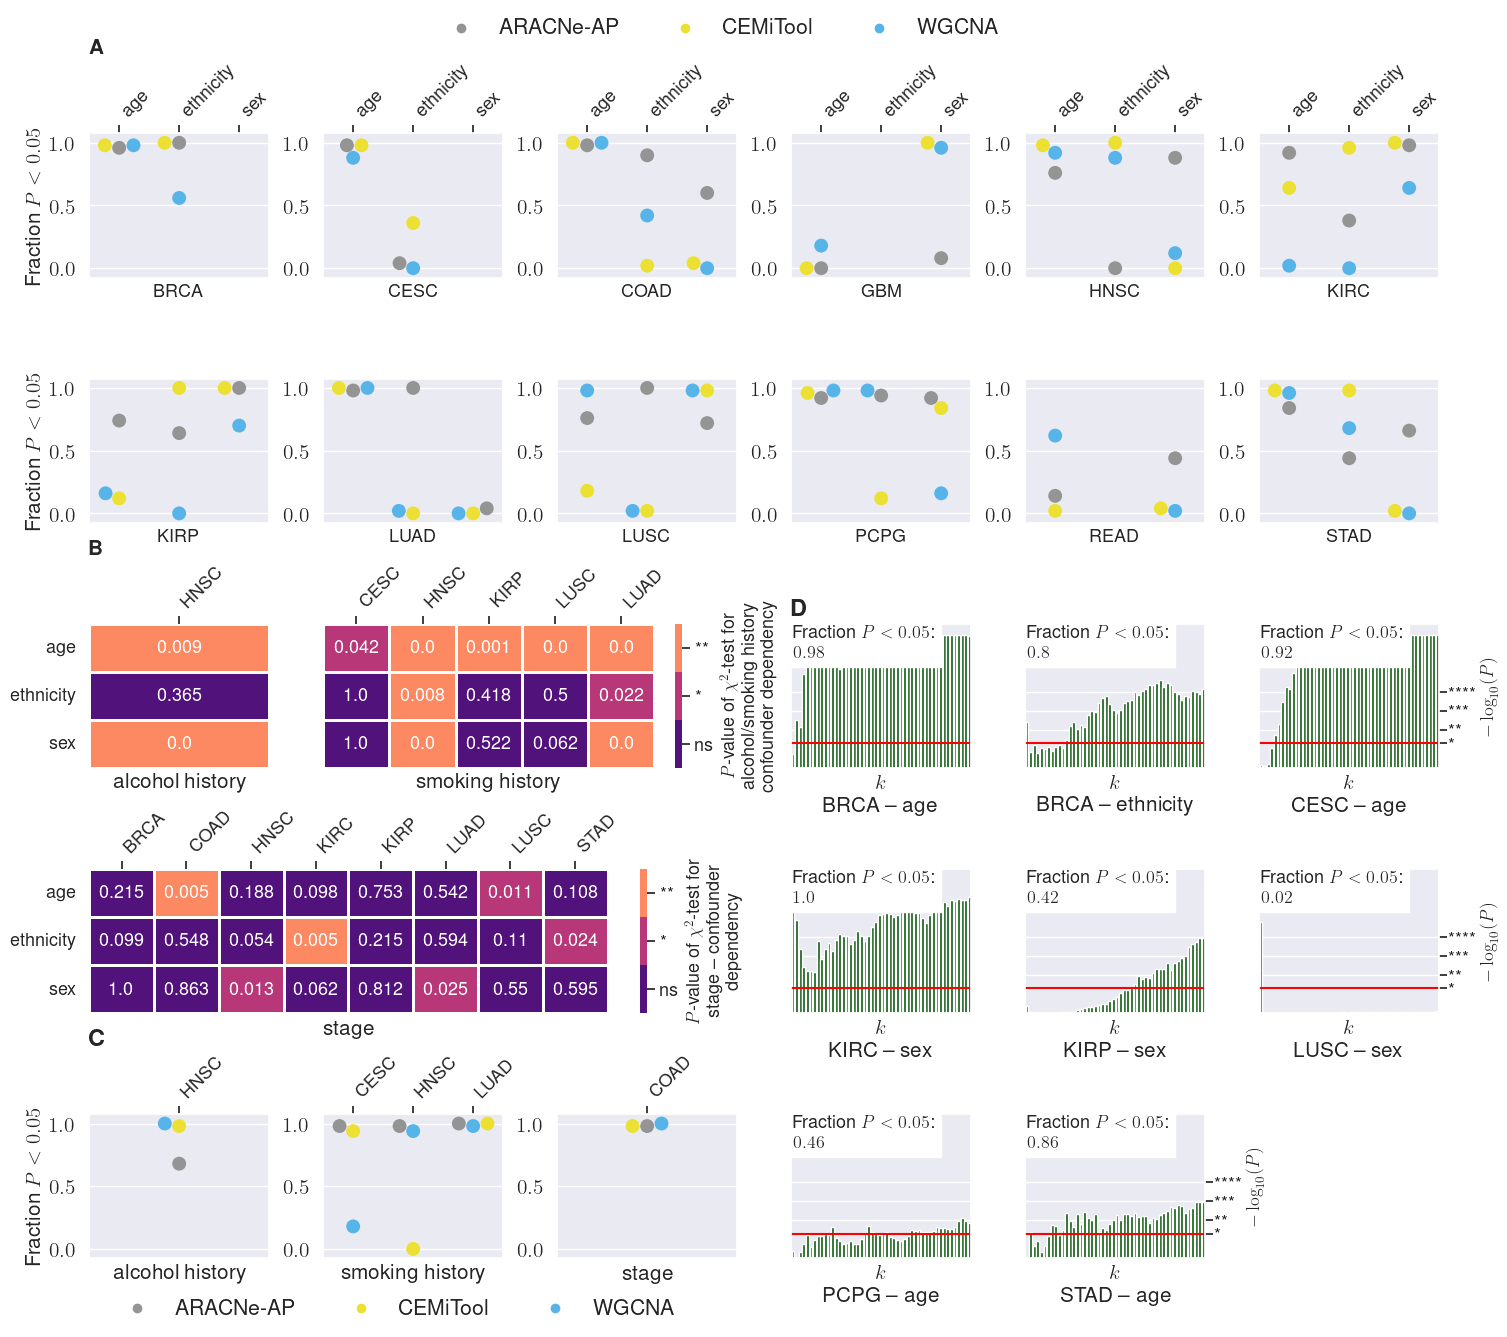

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='lef

<Figure size 640x480 with 0 Axes>

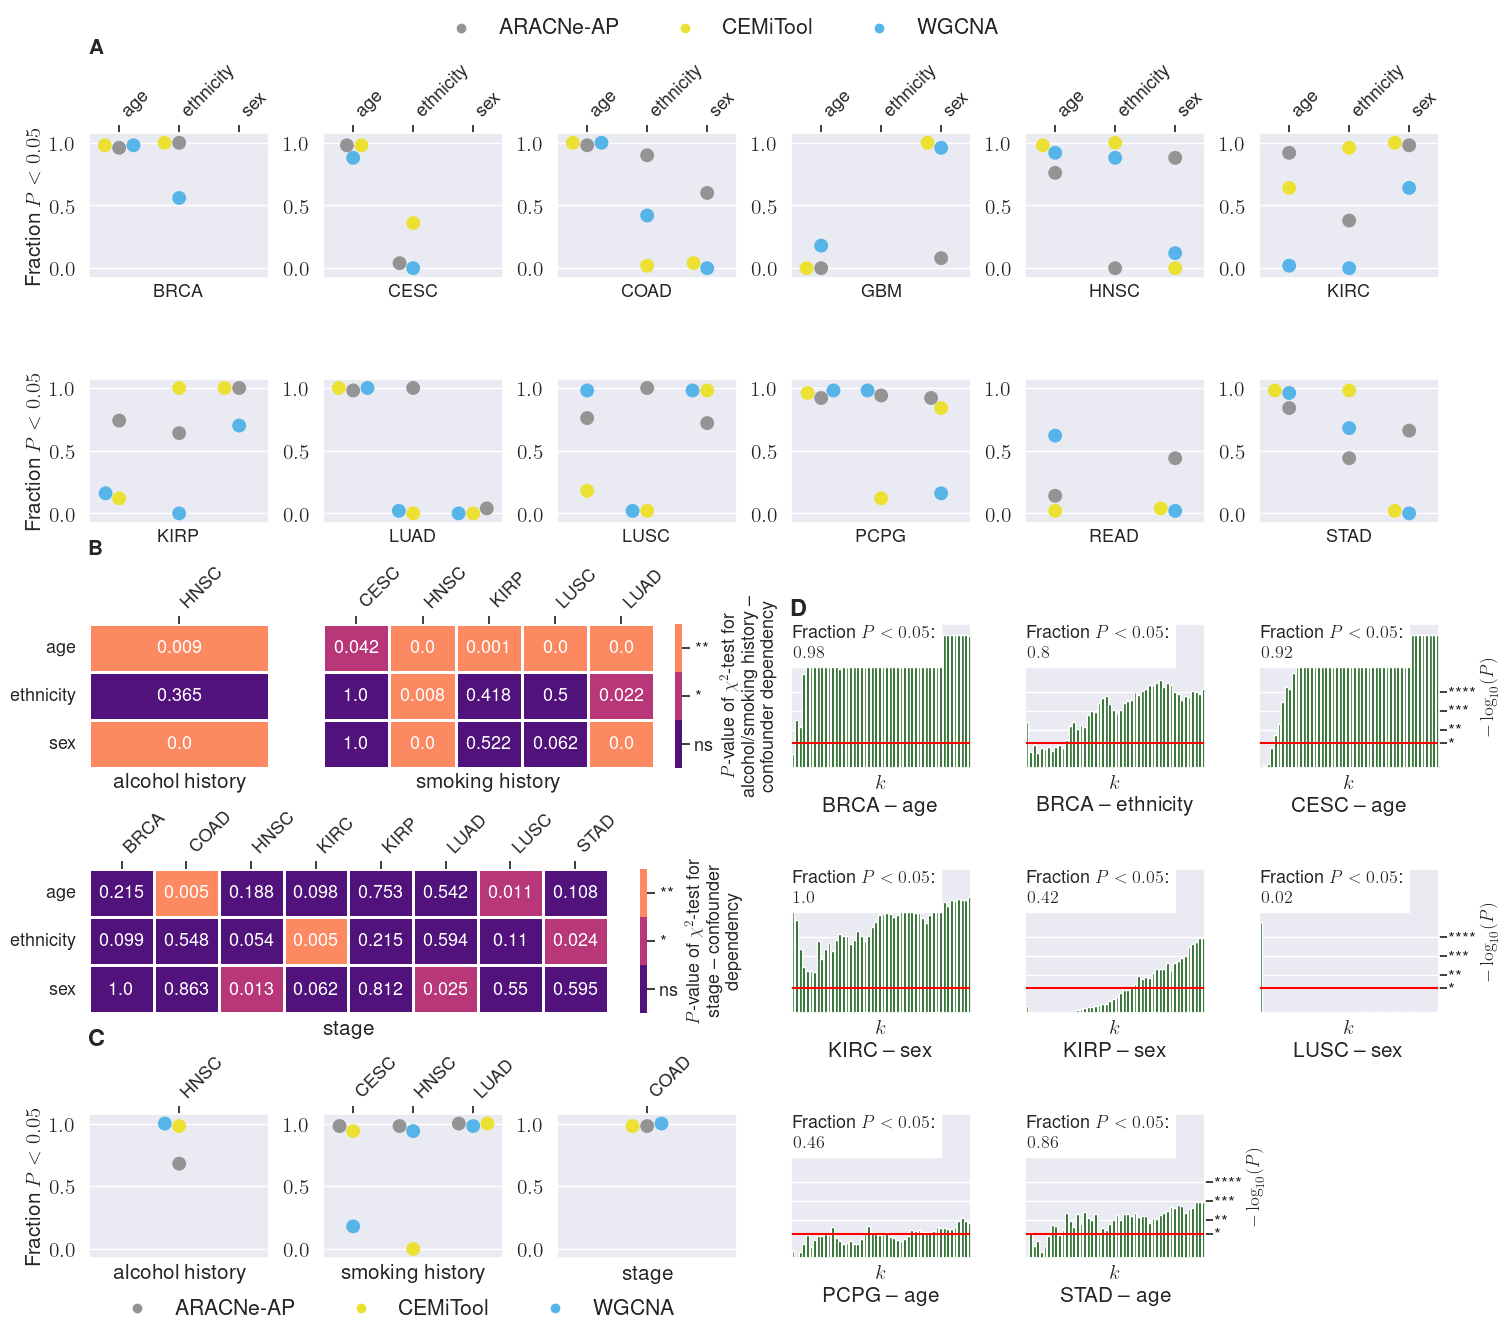

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/1280038985.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='lef

<Figure size 640x480 with 0 Axes>

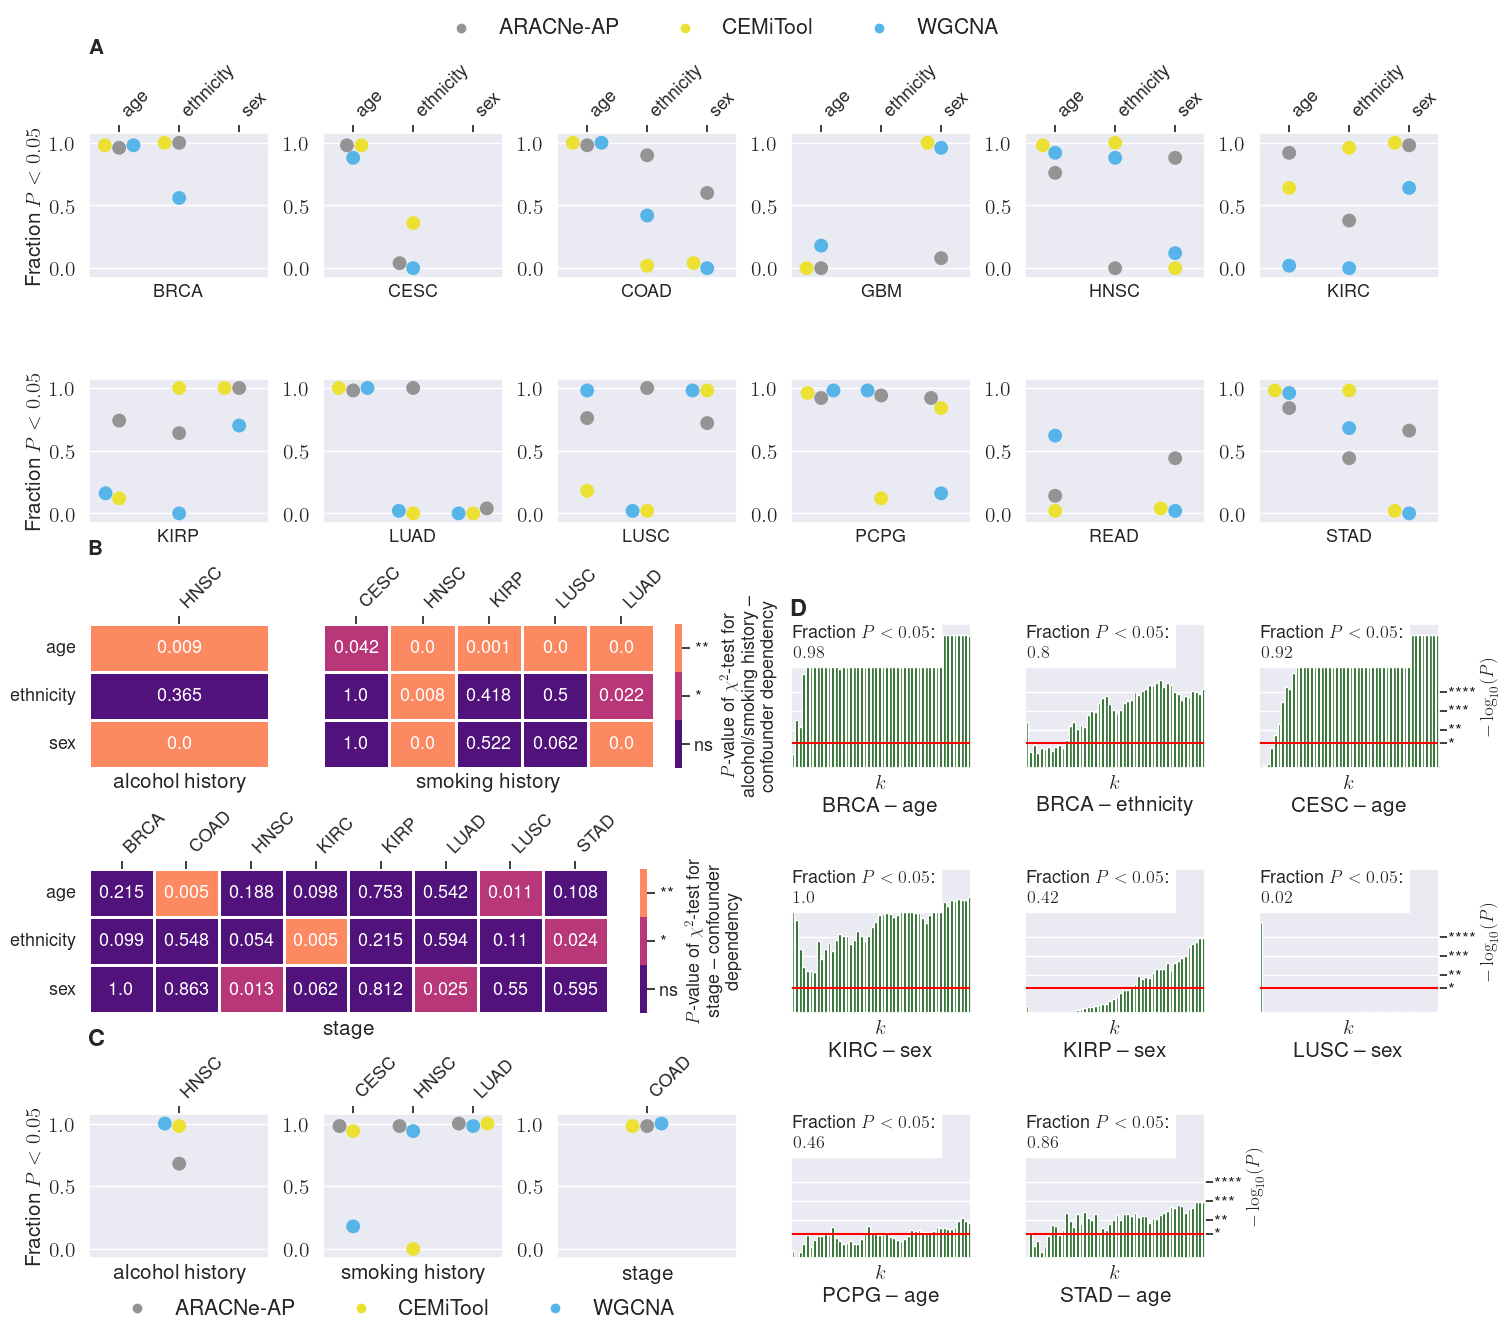

In [28]:
plt.tight_layout()
sns.set(font_scale=1.4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
mosaic = [ct_sels[:6],
         ct_sels[6:14],
         ['alcohol history '] + ['smoking history '] * 2 + cohort_confs[:3],
         ['stage '] * 3 + cohort_confs[3:6],
         ['alcohol history'] + ['smoking history'] + ['stage'] + cohort_confs[6:] + ['.']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(6*2.5,5*2.5),sharex=False, sharey=False)

### A
for ct_sel in ct_sels:
    _mwus_ct = _mwus_conf[_mwus_conf['Cohort'] == ct_sel]
    sns.swarmplot(data=_mwus_ct, ax=axs[ct_sel], x='Confounder/\nvariable', y='frac', hue='Method', s=10, palette=sns.color_palette('colorblind')[7:10])
    axs[ct_sel].set_ylim([-0.075, 1.075])
    if ct_sel == ct_sels[0]:
        axs[ct_sel].set_title(r'\textbf{A}',loc='left', fontsize=15)
        sns.move_legend(axs[ct_sel], "lower center", frameon=False, ncol=3, title=None, bbox_to_anchor=(3.5,1.53))
    else:
        axs[ct_sel].legend().set_visible(False)
    if ct_sel in ct_sels[:6]:
        axs[ct_sel].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        axs[ct_sel].set_xticklabels(axs[ct_sel].get_xticklabels(), rotation=45, ha='left',fontsize=13)
    else:
        axs[ct_sel].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    axs[ct_sel].set(xlabel=None, ylabel=None)
    axs[ct_sel].set_xlabel(ct_sel, fontsize=13)
    if ct_sel in [ct_sels[6*i] for i in range(2)]:
        axs[ct_sel].set_ylabel('Fraction $P<0.05$', labelpad=3, fontsize=15)

### B
cmap2 = sns.color_palette("magma", 3)
for df_work, ax in zip([alc_p, cig_p, stage_p], ['alcohol history ', 'smoking history ', 'stage ']):
    ast = pd.DataFrame(np.array([df_work['age'].apply(convert_pvalue_to_asterisks).to_numpy(),
                   df_work['ethnicity'].apply(convert_pvalue_to_asterisks).to_numpy(),
                   df_work['sex'].apply(convert_pvalue_to_asterisks).to_numpy()]), index=df_work.columns,
                    columns = df_work.index)#.T

    cur = df_work.T
    cur = round(cur, 3)
    plt.tight_layout()
    htm = sns.heatmap(ast, mask=ast.isnull(), ax=axs[ax], vmin=0, vmax=2, annot=cur, cmap=cmap2, cbar=((ax == 'smoking history ') or (ax == 'stage ')), 
                fmt = '', annot_kws={'fontsize':13}, linewidths=1)
    htm.set_facecolor('white')
    axs[ax].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation=45, ha='left',fontsize=13)
    axs[ax].set_xlabel(ax, fontsize=15)
    if ax == 'smoking history ':
        axs[ax].set_yticklabels([])
    else:
        axs['alcohol history '].set_yticklabels(axs[ax].get_ymajorticklabels(),fontsize=13,rotation=0)
        axs['stage '].set_yticklabels(axs[ax].get_ymajorticklabels(),fontsize=13,rotation=0)

colorbar = axs['smoking history '].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / 3 * (0.5 + i) for i in range(3)])
colorbar.set_ticklabels(['ns','*','**'], fontsize='13')
colorbar.set_label('$P$-value of $\chi^2$-test for\nalcohol/smoking history –\nconfounder dependency', fontsize='13')
colorbar = axs['stage '].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / 3 * (0.5 + i) for i in range(3)])
colorbar.set_ticklabels(['ns','*','**'], fontsize='13')
colorbar.set_label('$P$-value of $\chi^2$-test for\nstage – confounder\ndependency', fontsize='13')
axs['alcohol history '].set_title(r'\textbf{B}',loc='left', fontsize=15)
        
### C
for var in ['alcohol history', 'smoking history', 'stage']:
    _mwus_ct = _mwus_var[_mwus_var['Confounder/\nvariable'] == var]
    sns.swarmplot(data=_mwus_ct, ax=axs[var], x='Cohort', y='frac', hue='Method', s=10, palette=sns.color_palette('colorblind')[7:10], legend=(var=='alcohol history'))
    axs[var].set_ylim([-0.075, 1.075])
    if var == 'alcohol history':
        axs[var].set_title(r'\textbf{C}',loc='left', fontsize=17)
        sns.move_legend(axs[var], "lower center", frameon=False, ncol=3, title=None, bbox_to_anchor=(1.7,-0.55))
    else:
        axs[var].legend().set_visible(False)
    axs[var].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axs[var].set_xticklabels(axs[var].get_xticklabels(), rotation=45, ha='left',fontsize=13)
    axs[var].set(xlabel=None, ylabel=None)
    axs[var].set_xlabel(var, fontsize=15)
    if var == 'alcohol history':
        axs[var].set_ylabel('Fraction $P<0.05$', labelpad=3, fontsize=15)
        
### D
for cohort_conf in cohort_confs:
    axs[cohort_conf].set_ylim([0, 7.6])
    axs[cohort_conf].axhline(y=-np.log10(0.05), linestyle='-', color='red')
    axs[cohort_conf].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    mwus_cohort_conf = mwus[mwus['Cohort - Variable'] == cohort_conf]
    sns.barplot(data=mwus_cohort_conf, x='k', y='-log(p)', ax=axs[cohort_conf], color='darkgreen')
    axs[cohort_conf].set(ylabel=None)
    axs[cohort_conf].set_yticks([-np.log10(0.05),-np.log10(0.01),-np.log10(0.001),-np.log10(0.0001)])
    axs[cohort_conf].set_yticklabels([], fontsize=15)
    axs[cohort_conf].tick_params(axis='y', which='major', pad=0)
    axs[cohort_conf].set_xlabel('$k$\n'+cohort_conf, fontsize=15)
    if cohort_conf in [cohort_confs[i] for i in [2,5,7]]:
        axs[cohort_conf].set_ylabel('$-\log_{10}(P)$', fontsize=13,  labelpad=3)
        axs[cohort_conf].set_yticks([-np.log10(0.05),-np.log10(0.01),-np.log10(0.001),-np.log10(0.0001)])
        axs[cohort_conf].set_yticklabels(['*','**','***','****'], fontsize=13)
        axs[cohort_conf].tick_params(axis='y', which='major', pad=0)
        axs[cohort_conf].yaxis.set_label_position("right")
        axs[cohort_conf].yaxis.tick_right()
    if cohort_conf == cohort_confs[0]:
        axs[cohort_conf].set_title(r'\textbf{D}',loc='left', fontsize=17)
    frac = mwus_cohort_conf[mwus_cohort_conf['mwu.pvalue'] < 0.05].shape[0] / mwus_cohort_conf.shape[0]
    axs[cohort_conf].text(.01, .99, f'Fraction $P<0.05$:\n${frac}$', ha='left', va='top', transform=axs[cohort_conf].transAxes,
                          fontsize=13, backgroundcolor='white')
        
### Overall settings
fig.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=.95,
                    top=0.95,
                    wspace=0.3,
                    hspace=0.7)
fig.savefig('plots/fig2.pdf', bbox_inches='tight')

## Generate data frames for second part of the test protocol

In [31]:
JI = pd.read_csv('JI_all_g_all.csv')

## Plot results of second part of the test protocol

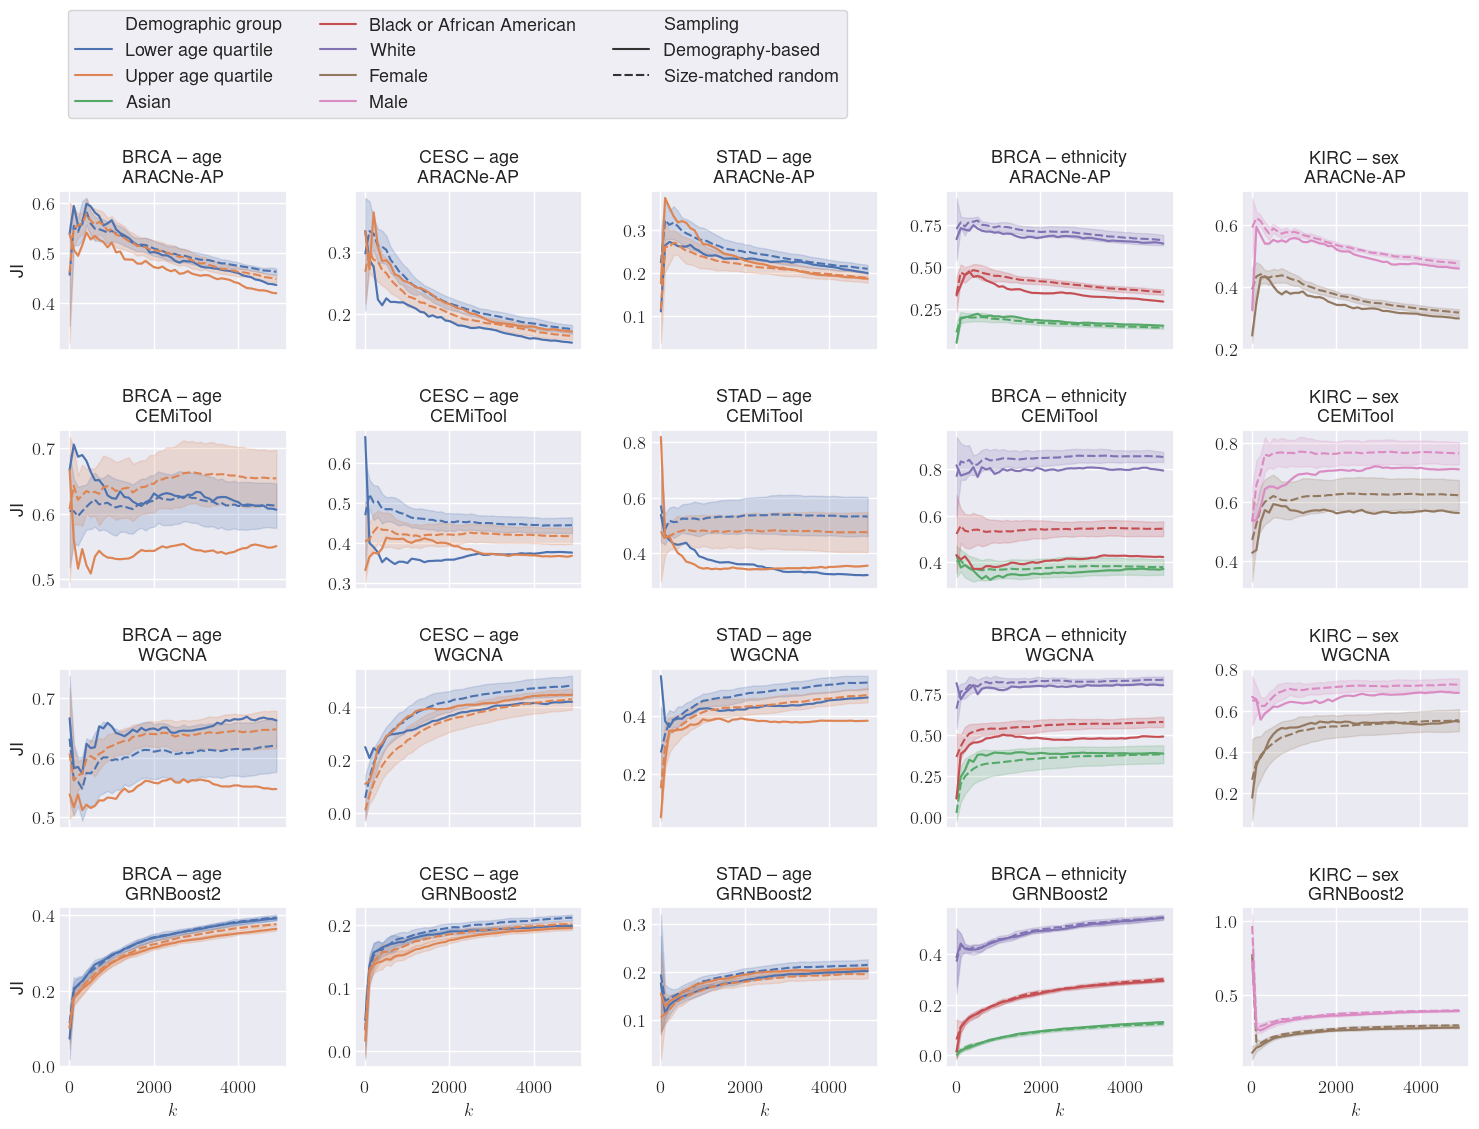

In [33]:
sns.set(font_scale=1.2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
selected_coco_pairs = ['BRCA – age', 'CESC – age','STAD – age','BRCA – ethnicity','KIRC – sex']
algos = list(set(JI['Method'].values))
algos = ['ARACNe-AP','CEMiTool', 'WGCNA', 'GRNBoost2']
fig, axs = plt.subplots(len(algos), len(selected_coco_pairs), figsize=(6*2.5, 3*len(algos)), sharex=True, sharey=False)
for j, coco in enumerate(selected_coco_pairs):
    JI_coco = JI[JI['Cohort – confounder'] == coco]
    for i, algo in enumerate(algos):
        JI_alg = JI_coco[JI_coco['Method'] == algo]
        sns.lineplot(data=JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[i,j], style='Sampling', hue='Demographic group')
        if i == 0 and j == 0:
            sns.move_legend(axs[i,j], "lower left", ncol=3, bbox_to_anchor=(0.0, 1.4), fontsize=13)
        else:
            axs[i,j].legend().set_visible(False)
        axs[i,j].set_title(f'{coco}\n{algo}', fontsize=13)
        axs[i,j].set_xlabel('$k$', fontsize=13)
        if j == 0:
            axs[i,j].set_ylabel('JI', fontsize=13)
        else:
            axs[i,j].set_ylabel('')
        axs[i,j].tick_params(axis='y',pad=-3)
fig.subplots_adjust(left=0.05,
                    bottom=0.06,
                    right=.99,
                    top=0.79,
                    wspace=0.3,
                    hspace=0.5)
fig.savefig('plots/fig3.pdf')

### Part 1 for the METABRIC BRCA (METABRIC) cohort

<Figure size 640x480 with 0 Axes>

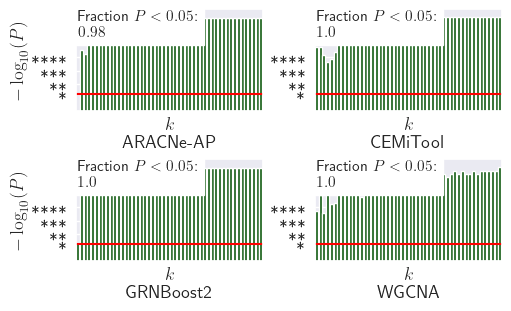

In [42]:
plt.tight_layout()
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set(font_scale=1.2)

manh = manh[(manh['Cohort'] == 'METABRIC') & (manh['Confounder/\nvariable'] == 'age')]
manh.reset_index(inplace=True)
manh['Cohort - Variable'] = manh['Cohort'] + ' – ' + manh['Confounder/\nvariable']
manh['k'] = pd.Categorical(manh['k'], range(10, 5000, 100))
manh['-log(p)'] = -np.log10(manh['mwu.pvalue'])
cohort_confs = sorted(list(set(manh['Cohort - Variable'].values)))
algs = ['ARACNe-AP', 'CEMiTool', 'GRNBoost2', 'WGCNA']

mosaic = [algs[0:2], algs[2:4]]

fig, axs = plt.subplot_mosaic(mosaic, figsize=(5,3),sharex=False, sharey=False, constrained_layout=True)

for alg in algs:
    manh_alg = manh[manh['Method'] == alg]
    cohort_conf = alg
    axs[cohort_conf].set_ylim([0, 7.6])
    axs[cohort_conf].axhline(y=-np.log10(0.05), linestyle='-', color='red')
    axs[cohort_conf].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    mwus_cohort_conf = manh_alg[manh_alg['Cohort - Variable'] == 'METABRIC – age']
    sns.barplot(data=mwus_cohort_conf, x='k', y='-log(p)', ax=axs[cohort_conf], color='darkgreen')
    axs[cohort_conf].set(ylabel=None)
    axs[cohort_conf].set_yticks([-np.log10(0.05),-np.log10(0.01),-np.log10(0.001),-np.log10(0.0001)])
    axs[cohort_conf].set_yticklabels(['*','**','***','****'], fontsize=13)
    axs[cohort_conf].tick_params(axis='y', which='major', pad=0)
    axs[cohort_conf].set_xlabel('$k$\n'+cohort_conf, fontsize=13)
    if alg == algs[0] or alg == algs[2]:
        axs[cohort_conf].set_ylabel('$-\log_{10}(P)$', fontsize=13,  labelpad=3)
    #if alg == algs[0]:
        #axs[cohort_conf].set_title('METABRIC BRCA (METABRIC)',loc='left', fontsize=11)
    frac = mwus_cohort_conf[mwus_cohort_conf['mwu.pvalue'] < 0.05].shape[0] / mwus_cohort_conf.shape[0]
    axs[cohort_conf].text(.01, .99, f'Fraction $P<0.05$:\n${frac}$', ha='left', va='top', transform=axs[cohort_conf].transAxes,
                          fontsize=11, backgroundcolor='white')
fig.savefig('plots/fig4.pdf')

## Part 2 for the METABRIC BRCA (METABRIC) cohort

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1918/881877426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['Demographic group'] = pd.Categorical(meta['Demographic group'], list(meta['Demographic group'].unique()))


<Figure size 640x480 with 0 Axes>

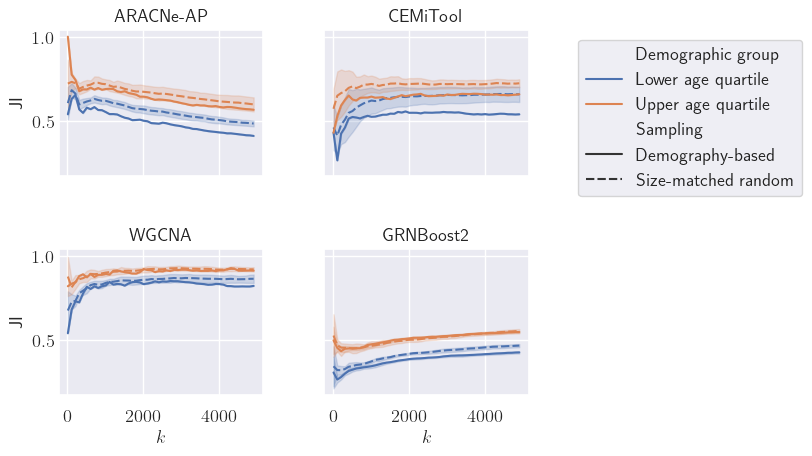

In [43]:
plt.tight_layout()
meta = JI[JI['Cohort – confounder'] == 'METABRIC – age']
meta['Demographic group'] = pd.Categorical(meta['Demographic group'], list(meta['Demographic group'].unique()))
mosaic = [algos[0:2], algos[2:4]]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(5,5),sharex=True, sharey=True)

for alg in algos:
    meta_alg = meta[meta['Method'] == alg]
    sns.lineplot(data=meta_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[alg], style='Sampling', hue='Demographic group')
    if alg == algs[0]:
        sns.move_legend(axs[alg], "lower left", ncol=1, bbox_to_anchor=(2.5, -0.2), fontsize=13)
    else:
        axs[alg].legend().set_visible(False)
    axs[alg].set_title(f'{alg}', fontsize=13)
    axs[alg].set_xlabel('$k$', fontsize=13)
    if alg == algos[0] or alg == algos[2]:
        axs[alg].set_ylabel('JI', fontsize=13)
    else:
        axs[alg].set_ylabel('')
    axs[alg].tick_params(axis='y',pad=-3)
fig.subplots_adjust(left=0.05,
                    bottom=0.06,
                    right=.99,
                    top=0.79,
                    wspace=0.3,
                    hspace=0.5)
    
fig.savefig('plots/METABRIC_part_B.pdf', bbox_inches='tight')